# Assess the performance metrics of a batch of SRlite

In [104]:
import plotnine
from plotnine import *
import pandas as pd
import glob

import os, sys
sys.path.append('/home/pmontesa/code/geoscitools')
import footprintlib

import numpy as np
import geopandas as gpd

In [3]:
import importlib
importlib.reload(footprintlib)

<module 'footprintlib' from '/home/pmontesa/code/geoscitools/footprintlib.py'>

# SRlite metrics analysis (example)  
- use this to filter validation & to inform training chip selection so you dont train with chips from bad data  
- develop this for Alaska in `code/geoscitools/above_shrubs_model_plan.ipynb`

#### Note: below SR data is a Senegal example, b/c metrics CSVs exist - switch to Alaska once CSVs are ready

In [117]:
# region_df_list = []
# SRLITE_REG_CHOICE = 'RMA'
# for REGION in ['CAS','ETZ','SRV']:
#     OUTDIR_TMP = f'/explore/nobackup/projects/ilab/data/srlite/products/srlite_1.0.1/srlite/senegal/{REGION}/csv'
#     srlite_metrics_df = pd.concat([footprintlib.get_attributes_from_filename(pd.read_csv(csv_fn), f'SR ({REGION})', f'_{SRLITE_REG_CHOICE}_SRLite_statistics', filename=os.path.basename(csv_fn), DROP_FILE_DUPLICATES=False) for csv_fn in glob.glob(OUTDIR_TMP + '/*.csv')])
#     region_df_list.append(srlite_metrics_df)

# srlite_metrics_df = pd.concat(region_df_list)

## SRlite metrics csvs for Alaska batches

In [52]:
region_df_list = []
SRLITE_REG_CHOICE = 'RMA'
for BATCH in ['batch_1']:
    
    for BAND_GROUP in ['4_band_csv','8_band_csv']:
        OUTDIR_TMP = f'/explore/nobackup/projects/ilab/data/srlite/products/srlite_1.0.1/srlite/alaska/{BATCH}/{BAND_GROUP}/**/csv'
        srlite_metrics_df = pd.concat([footprintlib.get_attributes_from_filename(pd.read_csv(csv_fn), f'SR ({BATCH} {BAND_GROUP})', f'_{SRLITE_REG_CHOICE}_SRLite_statistics', filename=os.path.basename(csv_fn), DROP_FILE_DUPLICATES=False) for csv_fn in glob.glob(OUTDIR_TMP + '/*.csv', recursive=True)])
        region_df_list.append(srlite_metrics_df)

srlite_metrics_df = pd.concat(region_df_list)

In [53]:
srlite_metrics_df.head()

,Unnamed: 0,index,band_name,model,intercept,slope,r2_score,explained_variance,mbe,mae,...,mae_norm,rmse_norm,file,type,footprint_name,catid,sensor,year,month,date
0,0,0,Blue,rma,0.005663,0.323203,-0.656420,-0.656397,0.000052,0.008060,...,0.193138,0.335974,WV02_20100502_M1BS_10300100045FA300_rma_SRLite...,SR (batch_1 4_band_csv),WV02_20100502_M1BS_10300100045FA300_rma_SRLite...,10300100045FA300,WV02,2010,5,2010-05-02
1,1,0,Green,rma,0.026435,0.369341,-0.518866,-0.518845,0.000059,0.008905,...,0.151890,0.267016,WV02_20100502_M1BS_10300100045FA300_rma_SRLite...,SR (batch_1 4_band_csv),WV02_20100502_M1BS_10300100045FA300_rma_SRLite...,10300100045FA300,WV02,2010,5,2010-05-02
2,2,0,Red,rma,0.023128,0.490886,-0.320911,-0.320899,0.000067,0.012457,...,0.196143,0.353727,WV02_20100502_M1BS_10300100045FA300_rma_SRLite...,SR (batch_1 4_band_csv),WV02_20100502_M1BS_10300100045FA300_rma_SRLite...,10300100045FA300,WV02,2010,5,2010-05-02
3,3,0,NIR,rma,0.026657,0.927631,0.391005,0.391021,0.000160,0.018976,...,0.110492,0.180501,WV02_20100502_M1BS_10300100045FA300_rma_SRLite...,SR (batch_1 4_band_csv),WV02_20100502_M1BS_10300100045FA300_rma_SRLite...,10300100045FA300,WV02,2010,5,2010-05-02
0,0,0,Blue,rma,-0.035856,0.609357,-0.410991,-0.410981,0.000050,0.010099,...,0.204498,0.375479,WV02_20100505_M1BS_1030010005215900_rma_SRLite...,SR (batch_1 4_band_csv),WV02_20100505_M1BS_1030010005215900_rma_SRLite...,1030010005215900,WV02,2010,5,2010-05-05


#### Get count of SRlite catids

In [75]:
z = srlite_metrics_df.groupby('catid').aggregate(catid_count=('catid','count'), band_count=('band_name','count'), type=('type','first')).reset_index() 
z.groupby('catid_count').aggregate(count=('catid_count','count'), type_count=('type','count')).reset_index() 

,catid_count,count,type_count
0,4,162,162
1,8,1915,1915
2,16,1,1


In [73]:
count_catid_bands = srlite_metrics_df.groupby('catid').aggregate(catid_count=('catid','count'), band_count=('band_name','count'), sensor=('sensor','first')).reset_index() 
print(count_catid_bands.shape)
count_catid_bands.groupby('catid_count').aggregate(count=('catid_count','count')).reset_index() 

(2078, 4)


,catid_count,count
0,4,162
1,8,1915
2,16,1


In [76]:
# get list of catids tjat have a more than 8 bands..
catid_check_list = count_catid_bands[count_catid_bands.catid_count > 8].catid.to_list()
srlite_metrics_df[srlite_metrics_df.catid.isin(catid_check_list)]

,Unnamed: 0,index,band_name,model,intercept,slope,r2_score,explained_variance,mbe,mae,...,mae_norm,rmse_norm,file,type,footprint_name,catid,sensor,year,month,date
0,0,0,Blue,rma,-0.194907,1.880811,-0.011984,-0.011984,0.000003,0.030029,...,0.501786,0.986751,WV02_20130617_M1BS_1030010024CC3100_rma_SRLite...,SR (batch_1 8_band_csv),WV02_20130617_M1BS_1030010024CC3100_rma_SRLite...,1030010024CC3100,WV02,2013,6,2013-06-17
1,1,0,Green,rma,-0.086716,1.465856,0.297502,0.298921,0.002281,0.024398,...,0.333951,0.694606,WV02_20130617_M1BS_1030010024CC3100_rma_SRLite...,SR (batch_1 8_band_csv),WV02_20130617_M1BS_1030010024CC3100_rma_SRLite...,1030010024CC3100,WV02,2013,6,2013-06-17
2,2,0,Red,rma,-0.046709,1.445930,0.303209,0.304505,0.002195,0.022857,...,0.425618,0.947888,WV02_20130617_M1BS_1030010024CC3100_rma_SRLite...,SR (batch_1 8_band_csv),WV02_20130617_M1BS_1030010024CC3100_rma_SRLite...,1030010024CC3100,WV02,2013,6,2013-06-17
3,3,0,NIR,rma,0.006447,0.959643,0.730470,0.730837,0.002542,0.038815,...,0.266230,0.472485,WV02_20130617_M1BS_1030010024CC3100_rma_SRLite...,SR (batch_1 8_band_csv),WV02_20130617_M1BS_1030010024CC3100_rma_SRLite...,1030010024CC3100,WV02,2013,6,2013-06-17
4,4,0,Coastal,rma,-0.194907,1.880811,NaN,NaN,NaN,NaN,...,NaN,NaN,WV02_20130617_M1BS_1030010024CC3100_rma_SRLite...,SR (batch_1 8_band_csv),WV02_20130617_M1BS_1030010024CC3100_rma_SRLite...,1030010024CC3100,WV02,2013,6,2013-06-17
5,5,0,Yellow,rma,-0.065632,1.455355,NaN,NaN,NaN,NaN,...,NaN,NaN,WV02_20130617_M1BS_1030010024CC3100_rma_SRLite...,SR (batch_1 8_band_csv),WV02_20130617_M1BS_1030010024CC3100_rma_SRLite...,1030010024CC3100,WV02,2013,6,2013-06-17
6,6,0,RedEdge,rma,-0.026563,1.261627,NaN,NaN,NaN,NaN,...,NaN,NaN,WV02_20130617_M1BS_1030010024CC3100_rma_SRLite...,SR (batch_1 8_band_csv),WV02_20130617_M1BS_1030010024CC3100_rma_SRLite...,1030010024CC3100,WV02,2013,6,2013-06-17
7,7,0,NIR2,rma,0.006447,0.959643,NaN,NaN,NaN,NaN,...,NaN,NaN,WV02_20130617_M1BS_1030010024CC3100_rma_SRLite...,SR (batch_1 8_band_csv),WV02_20130617_M1BS_1030010024CC3100_rma_SRLite...,1030010024CC3100,WV02,2013,6,2013-06-17
0,0,0,Blue,rma,-0.128475,1.364619,0.014768,0.014769,0.000029,0.014921,...,0.272964,0.800061,WV02_20130617_M1BS_1030010024CC3100_rma_SRLite...,SR (batch_1 8_band_csv),WV02_20130617_M1BS_1030010024CC3100_rma_SRLite...,1030010024CC3100,WV02,2013,6,2013-06-17
1,1,0,Green,rma,-0.068293,1.249035,0.259618,0.260359,0.001196,0.015297,...,0.217746,0.538176,WV02_20130617_M1BS_1030010024CC3100_rma_SRLite...,SR (batch_1 8_band_csv),WV02_20130617_M1BS_1030010024CC3100_rma_SRLite...,1030010024CC3100,WV02,2013,6,2013-06-17


In [77]:
glob.glob(OUTDIR_TMP + '/WV02_20130617_M1BS_1030010024CC3100*csv', recursive=True)

['/explore/nobackup/projects/ilab/data/srlite/products/srlite_1.0.1/srlite/alaska/batch_1/8_band_csv/split_3/csv/WV02_20130617_M1BS_1030010024CC3100_rma_SRLite_statistics.csv',
 '/explore/nobackup/projects/ilab/data/srlite/products/srlite_1.0.1/srlite/alaska/batch_1/8_band_csv/split_4/csv/WV02_20130617_M1BS_1030010024CC3100_rma_SRLite_statistics.csv']

In [ ]:
smry_dup_count = count_catid_bands.groupby('catid').aggregate(dup_count=('catid','count')).reset_index() 
smry_dup_count[smry_dup_count.dup_count > 1]

### Get vhr metadata from associated TOAs

In [51]:
#TODO

### Find catid for which all bands have r2_score > threshold

In [78]:
THRESH_R2_SCORE = 0.25

In [79]:
smry_catid_r2_score = srlite_metrics_df.groupby(['catid','band_name']).aggregate({'r2_score':'first'}).reset_index().groupby(['catid']).aggregate({'r2_score':'min'}).rename(columns={'r2_score':'r2_score_band_min'}).reset_index()
print(smry_catid_r2_score.shape)
smry_catid_r2_score.head()

(2078, 2)


,catid,r2_score_band_min
0,10300100045FA300,-0.656420
1,1030010005215900,-0.410991
2,1030010005333400,-0.970634
3,10300100053C1900,-0.425885
4,10300100054FCA00,-0.619197


In [80]:
proportion_gt_thresh_r2_score = np.round(len(smry_catid_r2_score[smry_catid_r2_score.r2_score_band_min > THRESH_R2_SCORE])/ len(smry_catid_r2_score), 3) * 100
proportion_gt_thresh_r2_score = proportion_gt_thresh_r2_score.astype(str) + '%'
proportion_gt_thresh_r2_score

'37.9%'

## Get final set of SRlite to use for training and model application

In [81]:
def classifier(row):
    if row["r2_score_band_min"] >= THRESH_R2_SCORE:
        return "include"
    else:
        return "exclude"

smry_catid_r2_score["srlite_use_class"] = smry_catid_r2_score.apply(classifier, axis=1)

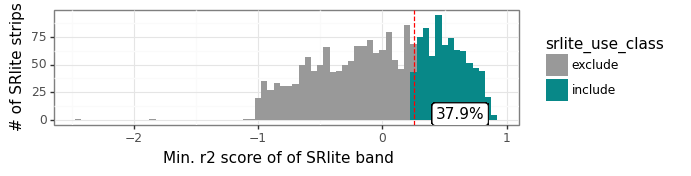

<ggplot: (1463548190552)>

In [82]:
(
    ggplot(smry_catid_r2_score.dropna())
    + geom_histogram(aes(x='r2_score_band_min', fill='srlite_use_class'), binwidth=0.05)
    + scale_fill_manual(values=['#999999','#088888'], name='')
    + geom_vline(xintercept=THRESH_R2_SCORE, color='red', linetype='dashed')
    + theme_bw()
    + theme(figure_size=(6,1.5))
    + labs(y='# of SRlite strips', x='Min. r2 score of of SRlite band')
    + geom_label(aes(x= THRESH_R2_SCORE + ( 0.5 * (1-THRESH_R2_SCORE)), y=5), label= (proportion_gt_thresh_r2_score))
    
)

### Make list of catids to include in modeling (train, apply)

In [83]:
# Get list of catids of class 'include'
list_catids_include = smry_catid_r2_score[smry_catid_r2_score.srlite_use_class == 'include'].catid.to_list()
len(list_catids_include)

788

In [121]:
# from code/geoscitools/footprint_vhr_AK.ipynb
footprints_vhr_meta_SR_gdf = gpd.read_file('/explore/nobackup/people/pmontesa/srlite/footprints_vhrmeta_SR_alaska.gpkg')
footprints_vhr_meta_SR_gdf[footprints_vhr_meta_SR_gdf.catid.isin(list_catids_include)].cx[-180:-125,50:75].to_crs(3338).plot(figsize=(10,5), alpha=0.5)

<AxesSubplot: >

## Plots show metrics separated by threshold of r2 score

NOTE! 8-band data only has values for slope and intercept - doesnt plot nicely - remove with `.dropna()`  

/home/pmontesa/.local/lib/python3.8/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 2 rows containing missing values.
/home/pmontesa/.local/lib/python3.8/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 2 rows containing missing values.


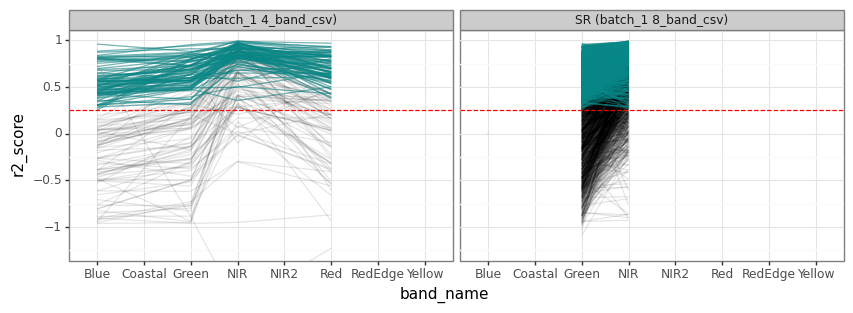

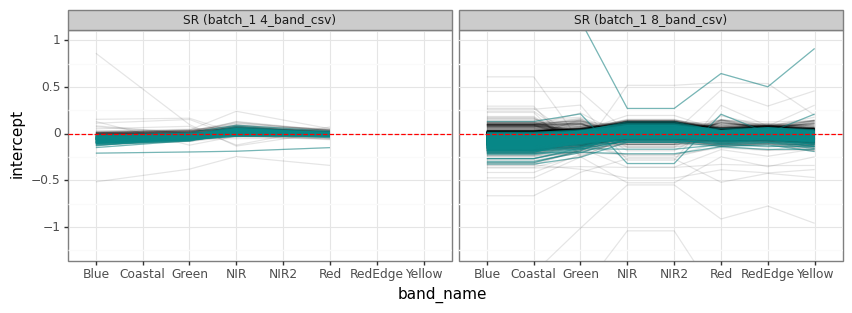

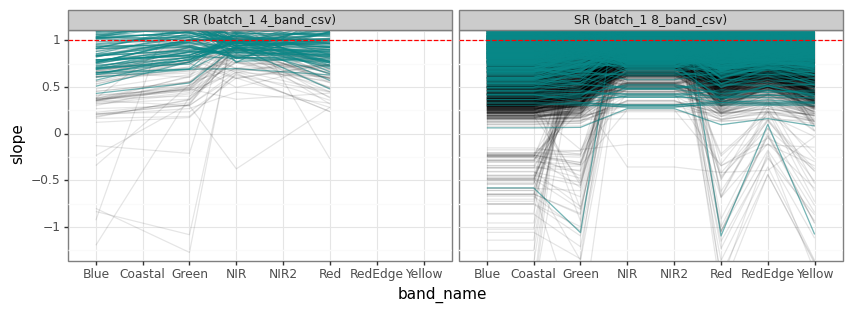

In [102]:

SUBSET_DF = srlite_metrics_df[srlite_metrics_df.catid.isin(list_catids_include)]#.dropna()
HLINE = [THRESH_R2_SCORE, 0, 1]

for i, Y_VAR in enumerate(['r2_score', 'intercept', 'slope']):
    print(
        ggplot(srlite_metrics_df)
            + geom_line(aes(x='band_name', y=Y_VAR, group='catid'), alpha=0.1)
        + geom_line(data = SUBSET_DF, mapping = aes(x='band_name', y=Y_VAR, group='catid'), alpha=0.5, color='#088888')
            + geom_hline(yintercept = HLINE[i], linetype='dashed', color='red')
            #+ geom_vline(xintercept=1, linetype='dashed', color='red')
            + facet_wrap('~type')
            + theme_bw()
            + coord_cartesian(ylim=(-1.25,1))
            #+ labs(title='SR-lite model parameters')
        + theme(figure_size=(10,3))
    )

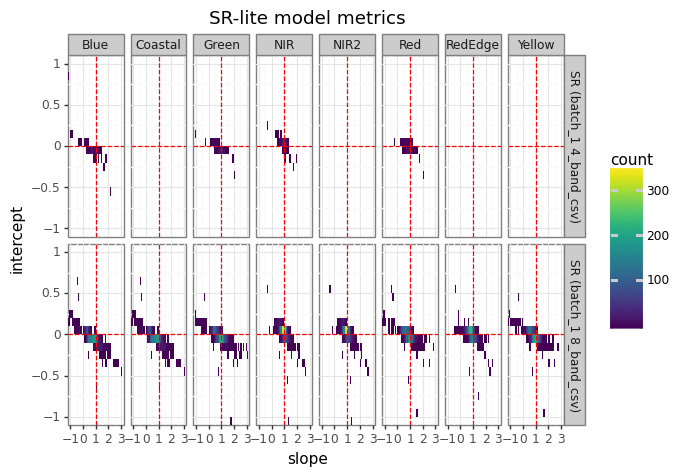

<ggplot: (1463200597679)>

In [123]:
(
    ggplot(srlite_metrics_df)
        + geom_bin2d(aes(x='slope', y='intercept'), binwidth=0.1)
        + geom_hline(yintercept=0, linetype='dashed', color='red')
        + geom_vline(xintercept=1, linetype='dashed', color='red')
        + facet_grid('type~band_name')
        + theme_bw()
        + coord_cartesian(xlim=(-1,3), ylim=(-1,1))
        + labs(title='SR-lite model metrics')
)

/home/pmontesa/.local/lib/python3.8/site-packages/plotnine/layer.py:333: PlotnineWarning: stat_bin_2d : Removed 7668 rows containing non-finite values.


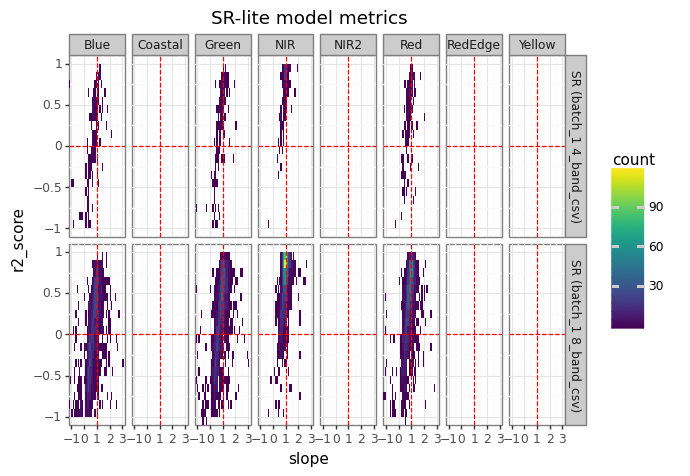

<ggplot: (1463548896660)>

In [124]:
(
    ggplot(srlite_metrics_df)
        + geom_bin2d(aes(x='slope', y='r2_score'), binwidth=0.1)
        + geom_hline(yintercept=0, linetype='dashed', color='red')
        + geom_vline(xintercept=1, linetype='dashed', color='red')
        + facet_grid('type~band_name')
        + theme_bw()
        + coord_cartesian(xlim=(-1,3), ylim=(-1,1))
        + labs(title='SR-lite model metrics')
)

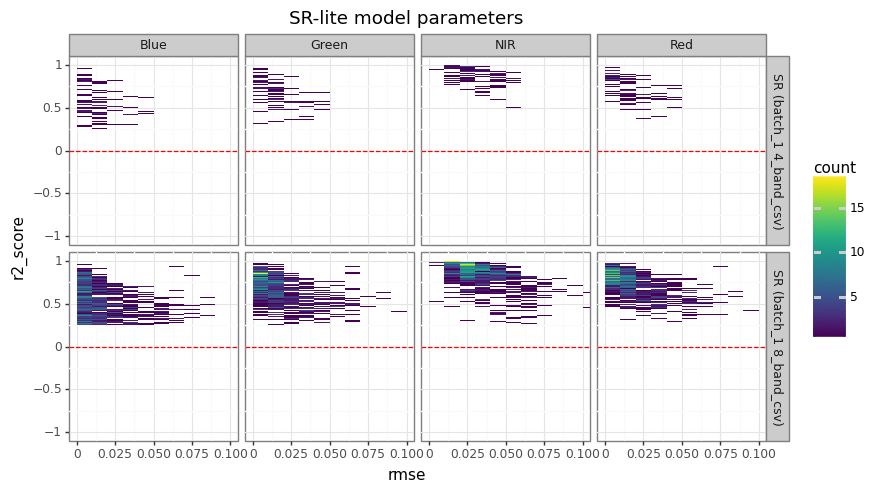

<ggplot: (1463190161869)>

In [97]:
(
    ggplot(SUBSET_DF.dropna())
        + geom_bin2d(aes(x='rmse', y='r2_score'), binwidth=0.01)
        + geom_hline(yintercept=0, linetype='dashed', color='red')
        + geom_vline(xintercept=1, linetype='dashed', color='red')
        + facet_grid('type~band_name')
        + theme_bw()
    + coord_cartesian(xlim=(0,0.1), ylim=(-1,1))
        + labs(title='SR-lite model parameters')
        + theme(figure_size=(9, 5), strip_text = element_text(size=9))
)

In [90]:
# (
#     ggplot(srlite_metrics_df.dropna())
#         + geom_point(aes(x='slope', y='r2_score', color='rmse'), size=0.25, alpha=0.91)
#         + geom_hline(yintercept=0, linetype='dashed', color='red')
#         + geom_vline(xintercept=1, linetype='dashed', color='red')
#         + facet_grid('type~band_name')
#         + theme_bw()
#     + coord_cartesian(xlim=(-1,3), ylim=(-1,1))
#         + labs(title='SR-lite model parameters')
#         + theme(figure_size=(9, 3), strip_text = element_text(size=9))
# )